In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import EA_funcs as eva
import matplotlib.pyplot as plt

In [2]:
np.random.seed(16)

# Introduction



All the selected portfolios are generated from the first year of data, and trained on the following 455 days of trading, except if stated otherwise in the description of the method used to generate the portfolio.

## Data

We use the assets from the S&P 100 stock index, removing the top 10 performers, to avoid our model latching into those and forcing it to search for more complex patterns. We use the first year for training and the remaining 453 days for evaluating.

In [3]:
data = eva.all_data

returns = data.pct_change().dropna()
cumulative = (1 + returns).cumprod() - 1

final_returns = cumulative.iloc[-1]
top_performers = final_returns.sort_values(ascending=False)
top_performers = top_performers[top_performers>1].index
data = data.drop(columns=top_performers)

split = int(0.7 * len(data))
train_data = data[:split]
test_data = data[split:]

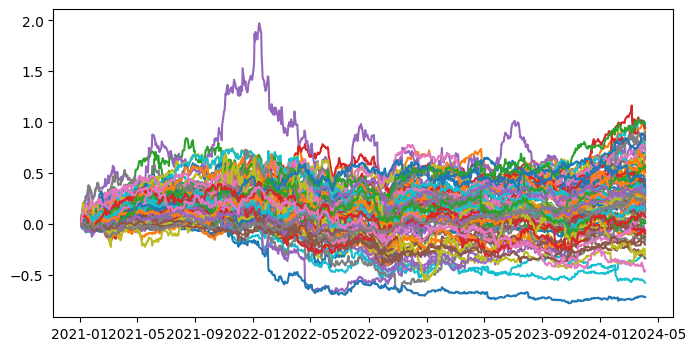

In [4]:
returns = data.pct_change().dropna()
cumulative = (1 + returns).cumprod() - 1

fig = plt.figure(figsize=(8, 4), dpi=100)
plt.plot(cumulative);

In [5]:
weights = eva.compute_all_weights(train_data, num_random=100_000, beta=0.18)

## Random portfolio generation:

Random portfolios (chromosomes) of the appropriate length are generated by sampling weights for each asset and normalizing them so their sum equals 1. Each gene in the chromosome corresponds to the allocation to one asset. Portfolios that satisfy specified constraints on maximum individual asset weight and overall portfolio risk are kept; those that don’t are discarded and replaced with new samples. This process continues until the desired population size—typically 100,000 portfolios—is reached.

Once the population is generated, the out-of-sample performance of each portfolio can be evaluated by calculating the cumulative returns over the test period. This random search method provides a useful benchmark by exploring a wide range of feasible portfolios without relying on complex optimization, allowing for a comparison point when assessing the value added by more sophisticated allocation strategies.

We can see that, although the best portfolio has expected returns of 18.6% on the training tada, when tested on a dynamic setting the actual profit was only 4.75%. This portfolio, therefore, was not robust enough, and failed in practice to approach the VMEX benchmark of ~21%.

Expected return (train): 10.135%
Risk (train): 16.762%


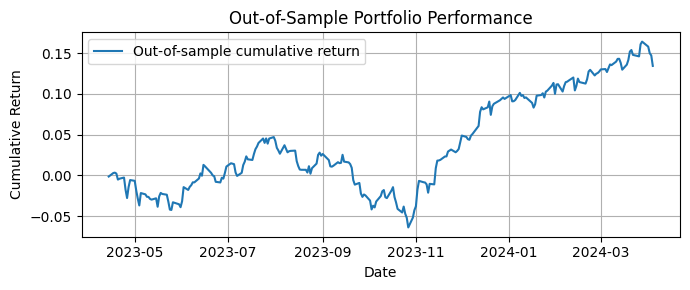

Actual return: 13.45%
Volatility during test: 10.49%


(0.1344820936998412, 0.10488085631381529)

In [6]:
eva.test_portfolio_weights(weights["Random Portfolios"], train_data, test_data)

## Equal Weight Portfolio

An equal weight portfolio is one in which each asset receives the same allocation, typically 
$1/𝑁$, for a portfolio of $𝑁$ assets. This simple approach doesn’t rely on forecasts or risk estimates, making it easy to implement and interpret.

Despite its simplicity, the equal weight portfolio plays an important role in portfolio analysis. It naturally avoids concentration in large or dominant assets, leading to a more balanced exposure across the investment universe. Because of its neutrality and lack of optimization, it is often used as a baseline or benchmark to evaluate whether more sophisticated allocation strategies actually provide added value. In practice, equal weight portfolios have sometimes performed surprisingly well, offering a useful point of comparison.

Every weight has the same value, given by

$$w_i = \frac{1}{N} \quad \text{for} \quad i = 1, 2, \ldots, N$$

Expected return (train): 7.456%
Risk (train): 17.147%


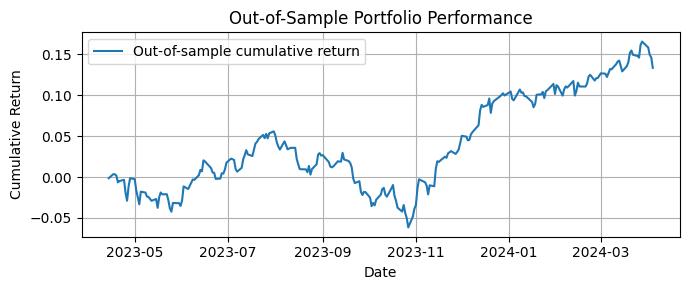

Actual return: 13.37%
Volatility during test: 10.99%


In [11]:
eva.test_portfolio_weights(weights["Equal Weight"], train_data, test_data);

## Inverse Volatility Weights

An inverse volatility portfolio allocates more weight to assets with lower historical volatility, assigning each asset a weight inversely proportional to its standard deviation. The idea is that less volatile assets contribute less to the portfolio’s overall risk, so increasing their weight can lead to more stable performance.

This method doesn’t require return forecasts, relying instead on observable data, which makes it both practical and transparent. It often serves as a useful benchmark when evaluating risk-based strategies, since it reduces exposure to highly volatile, potentially destabilizing assets. By prioritizing stability in this way, inverse volatility weighting offers a natural point of comparison for more complex risk optimization techniques.

Each weight is defined by 

$$% Inverse Volatility
w_i = \frac{\frac{1}{\sigma_i}}{\sum_{j=1}^N \frac{1}{\sigma_j}}\text{ ,}
$$
where $\sigma_i$ is the standard deviation of asset $i$

Expected return (train): 8.26%
Risk (train): 15.799%


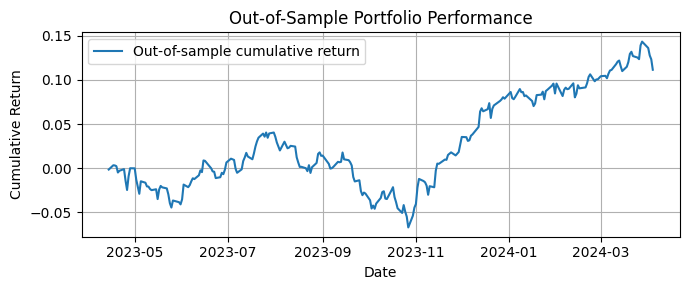

Actual return: 11.15%
Volatility during test: 10.32%


In [12]:
eva.test_portfolio_weights(weights["Inverse Volatility"], train_data, test_data);

## Minimum Variance Weights

A minimum variance portfolio is constructed by finding the asset weights that minimize the portfolio's overall volatility, based on the covariance structure of asset returns. It focuses purely on risk reduction, regardless of expected returns, and tends to tilt toward assets that not only have low individual volatility but also low correlations with others.

Because it emerges directly from modern portfolio theory, the minimum variance portfolio is often used as a benchmark for evaluating the effectiveness of more sophisticated optimization strategies. Its practical relevance lies in providing a baseline of risk efficiency—offering a clear reference point for how well other portfolios manage to balance diversification and volatility.

Weights are computed as 

$$
% Minimum Variance
\begin{aligned}
& \min_{\mathbf{w}} \quad \mathbf{w}^\top \Sigma \mathbf{w} \\
& \text{s.t.} \quad \sum_{i=1}^N w_i = 1, \quad w_i \geq 0
\end{aligned} \text{ ,}
$$

where $\Sigma$ is the covariance matrix of asset returns.

Expected return (train): 7.456%
Risk (train): 17.147%


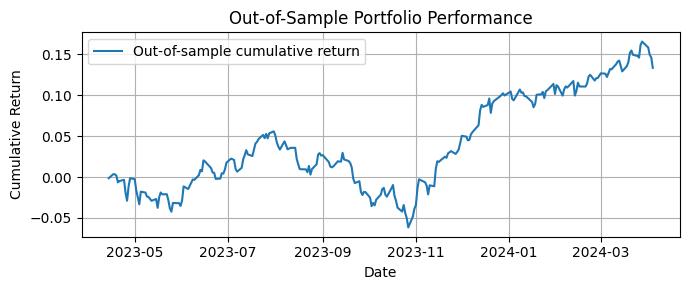

Actual return: 13.37%
Volatility during test: 10.99%


In [9]:
eva.test_portfolio_weights(weights["Minimum Variance"], train_data, test_data);

## Hierarchical Risk Parity

Hierarchical Risk Parity (HRP) is a portfolio allocation method that combines hierarchical clustering with risk parity principles. Instead of relying on traditional optimization, HRP builds a portfolio by first organizing assets into a hierarchy based on their correlations, then sequentially allocating capital in a way that balances risk across the resulting structure.

One of HRP’s strengths lies in its ability to produce diversified portfolios without the numerical instability or sensitivity to estimation errors that often affect mean-variance optimization. As such, HRP serves as a practical benchmark for robust, risk-aware allocation—especially when working with noisy covariance matrices or a large number of assets. It provides a natural comparison point for evaluating methods that aim to improve risk-adjusted returns in complex market environments.

Weights are allocated recursively through hierarchical clustering:

Compute asset distances from correlations.

Build a dendrogram clustering assets.

Recursively split clusters and allocate weights to balance cluster variances.

Formally, weights for clusters $C_1$, $C_2$ are assigned by:

$$
% Hierarchical Risk Parity (HRP)
\alpha = 1 - \frac{\mathrm{Var}(C_1)}{\mathrm{Var}(C_1) + \mathrm{Var}(C_2)}
$$

Weights within clusters are scaled accordingly in a bottom-up manner (*i.e.* starting with assets within the smallest clusters).

Expected return (train): 8.297%
Risk (train): 14.309%


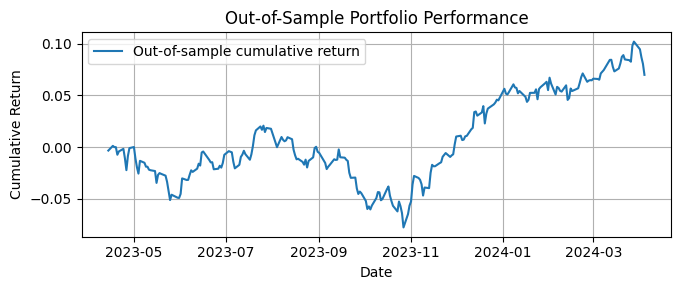

Actual return: 6.99%
Volatility during test: 9.74%


In [10]:
eva.test_portfolio_weights(weights["HRP"], train_data, test_data);